In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import keras
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras.optimizers import RMSprop
from keras import Model
from keras.models import load_model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.shape

(7095, 3)

In [6]:
df_train.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
46,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
47,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
51,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
56,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
57,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


### Utility functions

In [7]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [8]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

### Model in Keras

In [31]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT = 256
TRAIN_IMG_SIZE_WIDTH = 1600

BATCH_SIZE = 4

NO_OF_CLASSES = 4

PATIENCE = 2
EPOCHS = 1


In [11]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_V3_4(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, batch_size = 1, n_channels=1, n_classes=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 shear_range=0.0, zoom_range=0.0,
                 rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, 
                 horizontal_flip=False, vertical_flip=False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0,
                 shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.img_normalize = img_normalize
        self.img_center = img_center
        self.img_standardize = img_standardize
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.shuffle = shuffle
        self.datagen_img = ImageDataGenerator(samplewise_center=img_center, samplewise_std_normalization=img_standardize, 
                                          rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range,
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='float32')

        self.datagen_mask = ImageDataGenerator(rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range, 
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='bool')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            orig_img_shape = img.shape[0:2]
            if self.use_unsharp_mask:
                img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
            if orig_img_shape != self.outcome_img_shape:
                img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img

            mask = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *orig_img_shape)            
            if orig_img_shape != self.outcome_img_shape:
                mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,(int(self.df['ClassId'].iloc[indexes[idx]]) - 1)] = mask
         
        seed = 13
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=self.batch_size, shuffle=False)
        mask_generator = self.datagen_mask.flow(y, seed=seed, batch_size=self.batch_size, shuffle=False)
        
        X_arg = np.empty((self.batch_size*2, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y_arg = np.empty((self.batch_size*2, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        
        (X_list, y_list) = zip(image_generator, mask_generator).__next__()
        for i in range(len(X_list)):
            X_arg[i,] = X[i,]
            y_arg[i,:,:,:] = y[i,:,:,:]
            X_arg[i + self.batch_size] = X_list[i]
            y_arg[i + self.batch_size] = y_list[i]

        return X_arg, y_arg

In [12]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [13]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def advanced_unet_256x1600_segmentation_model(input_shape=(256, 1600, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    down_2 = Conv2D(8, (3, 3), padding='same')(inputs)
    down_2 = BatchNormalization()(down_2)
    down_2 = Activation('relu')(down_2)
    down_2 = Conv2D(8, (3, 3), padding='same')(down_2)
    down_2 = BatchNormalization()(down_2)
    down_2 = Activation('relu')(down_2)
    down_2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_2)

    down_1 = Conv2D(16, (3, 3), padding='same')(down_2_pool)
    down_1 = BatchNormalization()(down_1)
    down_1 = Activation('relu')(down_1)
    down_1 = Conv2D(16, (3, 3), padding='same')(down_1)
    down_1 = BatchNormalization()(down_1)
    down_1 = Activation('relu')(down_1)
    down_1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_1)
    
    down0 = Conv2D(32, (3, 3), padding='same')(down_1_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 1), strides=(2, 1))(down4)

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up4 = UpSampling2D((2, 1))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2) 

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)

    up_1 = UpSampling2D((2, 2))(up0)
    up_1 = concatenate([down_1, up_1], axis=3)
    up_1 = Conv2D(16, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)
    up_1 = Conv2D(16, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)
    up_1 = Conv2D(16, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)

    up_2 = UpSampling2D((2, 2))(up_1)
    up_2 = concatenate([down_2, up_2], axis=3)
    up_2 = Conv2D(8, (3, 3), padding='same')(up_2)
    up_2 = BatchNormalization()(up_2)
    up_2 = Activation('relu')(up_2)
    up_2 = Conv2D(8, (3, 3), padding='same')(up_2)
    up_2 = BatchNormalization()(up_2)
    up_2 = Activation('relu')(up_2)
    up_2 = Conv2D(8, (3, 3), padding='same')(up_2)
    up_2 = BatchNormalization()(up_2)
    up_2 = Activation('relu')(up_2)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up_2)

    model = Model(inputs=inputs, outputs=classify)
    
    return model

In [14]:
advanced_model = advanced_unet_256x1600_segmentation_model(num_classes=4)
advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])
advanced_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 1600, 8) 32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 1600, 8) 0           batch_normalization_1[0][0]      
_____________________________________

activation_11 (Activation)      (None, 8, 50, 256)   0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 8, 50, 256)   590080      activation_11[0][0]              
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 8, 50, 256)   1024        conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 8, 50, 256)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 4, 25, 256)   0           activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_13 

up_sampling2d_3 (UpSampling2D)  (None, 16, 100, 256) 0           activation_22[0][0]              
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 16, 100, 384) 0           activation_10[0][0]              
                                                                 up_sampling2d_3[0][0]            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 16, 100, 128) 442496      concatenate_3[0][0]              
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 16, 100, 128) 512         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 16, 100, 128) 0           batch_normalization_23[0][0]     
__________

batch_normalization_33 (BatchNo (None, 128, 800, 16) 64          conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 128, 800, 16) 0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 128, 800, 16) 2320        activation_33[0][0]              
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 128, 800, 16) 64          conv2d_34[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 128, 800, 16) 0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
up_samplin

In [23]:
layer = advanced_model.get_layer(index=109)
print(layer.get_config())

{'name': 'batch_normalization_31', 'trainable': True, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}


In [17]:
# This layer has 3x3x16x16 = 2320 params (weights) 
layer = advanced_model.get_layer(index=11)
layer_256x1600_initially = layer.get_weights()[0][2][2][15]
print(layer_256x1600_initially)

[-0.1164664   0.09346746 -0.00426714 -0.09404384  0.1425933  -0.14255296
  0.01436068  0.08169857 -0.02896807  0.06693725 -0.05650454 -0.0236631
  0.07360651 -0.05841386  0.02960557  0.07286337]


In [18]:
# This layer has 1x16 = 16 params (weights) 
print(len(layer.get_weights()[1]))

# Combined this model has 2304 + 16 params = 2320 params (weights) as illustrated above for index 11

16


In [19]:
model_128x800 = load_model('./models/unet_model_128x800_unsharp_4classes_v1.h5', 
                          custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

Instructions for updating:
Use tf.cast instead.


In [20]:
model_128x800.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 800, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 800, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 800, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 4, 25, 512)   2048        conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 4, 25, 512)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 2, 25, 512)   0           activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 2, 25, 1024)  4719616     max_pooling2d_6[0][0]            
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 2, 25, 1024)  4096        conv2d_13[0][0]                  
__________

conv2d_23 (Conv2D)              (None, 16, 100, 128) 147584      activation_22[0][0]              
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 16, 100, 128) 512         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 16, 100, 128) 0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, 32, 200, 128) 0           activation_23[0][0]              
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 32, 200, 192) 0           activation_6[0][0]               
                                                                 up_sampling2d_4[0][0]            
__________

In [24]:
layer_128x800 = model_128x800.get_layer(index=102)
print(layer_128x800.get_config())

{'name': 'batch_normalization_29', 'trainable': True, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}


#### Moving weights from low res. sub-model to higher res. including model

We are now going to marry up layers with index 11 to 102 for the advanced_model with the pre-trained weights for the 64x400 model whose indexes are 4 to 95

In [25]:
# Takes roughly a minute
for idx in range(4, 103):
    layer_128x800 = model_128x800.get_layer(index=idx)
    layer_256x1600 = advanced_model.get_layer(index=(idx + 7))
    layer_256x1600.set_weights(layer_128x800.get_weights())  
    layer_256x1600.trainable=False

In [26]:
advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [28]:
layer = advanced_model.get_layer(index=11)
print(layer.get_config())

layer_256x1600_initially = layer.get_weights()[0][2][2][15]
print(layer_256x1600_initially)

{'name': 'conv2d_4', 'trainable': False, 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[ 0.19774145  0.0426113   0.00757337 -0.06391622  0.10728361  0.08970336
  0.09039313 -0.1798031   0.07129601  0.01274211 -0.15537432  0.01191017
 -0.18142171 -0.13882028  0.03663984 -0.03118151]


#### Back to training

In [29]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss',
        min_delta = 0.005,
        patience=patient, 
        mode='min', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient//2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='min')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./unet_model_256x1600_unsharp_4classes_v1.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
#    return [ES, MC, LR]
    return [ES, MC, RR]


In [32]:
# 1 EPOCH: dice_coeff: 0.2255 - acc: 0.0521 - val_loss: -0.8723 - val_dice_coeff: 0.4503 - val_acc: 0.0488

idx = int(0.8*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/1


 131/1419 [=>............................] - ETA: 1:23:42 - loss: 0.1938 - dice_coeff: 0.0341 - acc: 0.045 - ETA: 1:15:51 - loss: 0.2253 - dice_coeff: 0.0190 - acc: 0.036 - ETA: 1:13:17 - loss: 0.2087 - dice_coeff: 0.0255 - acc: 0.039 - ETA: 1:12:12 - loss: 0.2150 - dice_coeff: 0.0241 - acc: 0.033 - ETA: 1:11:24 - loss: 0.2073 - dice_coeff: 0.0274 - acc: 0.034 - ETA: 1:10:50 - loss: 0.1731 - dice_coeff: 0.0434 - acc: 0.054 - ETA: 1:10:28 - loss: 0.1757 - dice_coeff: 0.0414 - acc: 0.051 - ETA: 1:10:03 - loss: 0.1742 - dice_coeff: 0.0419 - acc: 0.052 - ETA: 1:09:45 - loss: 0.1655 - dice_coeff: 0.0458 - acc: 0.056 - ETA: 1:09:34 - loss: 0.1693 - dice_coeff: 0.0435 - acc: 0.053 - ETA: 1:09:17 - loss: 0.1658 - dice_coeff: 0.0446 - acc: 0.053 - ETA: 1:07:36 - loss: 0.1570 - dice_coeff: 0.0483 - acc: 0.056 - ETA: 1:06:07 - loss: 0.1533 - dice_coeff: 0.0493 - acc: 0.056 - ETA: 1:04:53 - loss: 0.1360 - dice_coeff: 0.0570 - acc: 0.063 - ETA: 1:03:45 - loss: 0.1322 - dice_coeff: 0.0585 - acc: 0.0

 263/1419 [====>.........................] - ETA: 48:01 - loss: 0.1048 - dice_coeff: 0.0583 - acc: 0.048 - ETA: 47:57 - loss: 0.1053 - dice_coeff: 0.0580 - acc: 0.048 - ETA: 47:55 - loss: 0.1060 - dice_coeff: 0.0576 - acc: 0.047 - ETA: 47:53 - loss: 0.1061 - dice_coeff: 0.0574 - acc: 0.047 - ETA: 47:50 - loss: 0.1045 - dice_coeff: 0.0581 - acc: 0.048 - ETA: 47:46 - loss: 0.1050 - dice_coeff: 0.0578 - acc: 0.047 - ETA: 47:44 - loss: 0.1049 - dice_coeff: 0.0578 - acc: 0.047 - ETA: 47:41 - loss: 0.1047 - dice_coeff: 0.0578 - acc: 0.047 - ETA: 47:38 - loss: 0.1044 - dice_coeff: 0.0578 - acc: 0.047 - ETA: 47:35 - loss: 0.1046 - dice_coeff: 0.0576 - acc: 0.047 - ETA: 47:34 - loss: 0.1049 - dice_coeff: 0.0574 - acc: 0.047 - ETA: 47:31 - loss: 0.1049 - dice_coeff: 0.0573 - acc: 0.047 - ETA: 47:29 - loss: 0.1054 - dice_coeff: 0.0570 - acc: 0.047 - ETA: 47:26 - loss: 0.1049 - dice_coeff: 0.0572 - acc: 0.047 - ETA: 47:24 - loss: 0.1052 - dice_coeff: 0.0570 - acc: 0.046 - ETA: 47:21 - loss: 0.1048

 395/1419 [=======>......................] - ETA: 42:39 - loss: 0.0825 - dice_coeff: 0.0602 - acc: 0.045 - ETA: 42:37 - loss: 0.0821 - dice_coeff: 0.0603 - acc: 0.045 - ETA: 42:35 - loss: 0.0823 - dice_coeff: 0.0602 - acc: 0.045 - ETA: 42:32 - loss: 0.0821 - dice_coeff: 0.0602 - acc: 0.045 - ETA: 42:30 - loss: 0.0823 - dice_coeff: 0.0601 - acc: 0.045 - ETA: 42:27 - loss: 0.0823 - dice_coeff: 0.0600 - acc: 0.045 - ETA: 42:24 - loss: 0.0812 - dice_coeff: 0.0605 - acc: 0.045 - ETA: 42:22 - loss: 0.0813 - dice_coeff: 0.0604 - acc: 0.045 - ETA: 42:19 - loss: 0.0814 - dice_coeff: 0.0602 - acc: 0.045 - ETA: 42:17 - loss: 0.0812 - dice_coeff: 0.0602 - acc: 0.045 - ETA: 42:15 - loss: 0.0807 - dice_coeff: 0.0604 - acc: 0.045 - ETA: 42:13 - loss: 0.0808 - dice_coeff: 0.0603 - acc: 0.045 - ETA: 42:10 - loss: 0.0808 - dice_coeff: 0.0603 - acc: 0.045 - ETA: 42:08 - loss: 0.0802 - dice_coeff: 0.0605 - acc: 0.045 - ETA: 42:05 - loss: 0.0804 - dice_coeff: 0.0603 - acc: 0.045 - ETA: 42:03 - loss: 0.0801

 527/1419 [==========>...................] - ETA: 37:31 - loss: 0.0543 - dice_coeff: 0.0664 - acc: 0.046 - ETA: 37:28 - loss: 0.0542 - dice_coeff: 0.0664 - acc: 0.046 - ETA: 37:26 - loss: 0.0541 - dice_coeff: 0.0664 - acc: 0.046 - ETA: 37:24 - loss: 0.0541 - dice_coeff: 0.0663 - acc: 0.046 - ETA: 37:22 - loss: 0.0541 - dice_coeff: 0.0663 - acc: 0.046 - ETA: 37:20 - loss: 0.0540 - dice_coeff: 0.0663 - acc: 0.046 - ETA: 37:17 - loss: 0.0537 - dice_coeff: 0.0664 - acc: 0.046 - ETA: 37:15 - loss: 0.0534 - dice_coeff: 0.0664 - acc: 0.046 - ETA: 37:14 - loss: 0.0532 - dice_coeff: 0.0665 - acc: 0.046 - ETA: 37:12 - loss: 0.0529 - dice_coeff: 0.0666 - acc: 0.046 - ETA: 37:09 - loss: 0.0528 - dice_coeff: 0.0666 - acc: 0.046 - ETA: 37:07 - loss: 0.0526 - dice_coeff: 0.0667 - acc: 0.046 - ETA: 37:05 - loss: 0.0524 - dice_coeff: 0.0667 - acc: 0.046 - ETA: 37:03 - loss: 0.0525 - dice_coeff: 0.0666 - acc: 0.046 - ETA: 37:00 - loss: 0.0524 - dice_coeff: 0.0666 - acc: 0.046 - ETA: 36:58 - loss: 0.0523

 659/1419 [============>.................] - ETA: 32:35 - loss: 0.0346 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:32 - loss: 0.0346 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:30 - loss: 0.0347 - dice_coeff: 0.0691 - acc: 0.045 - ETA: 32:28 - loss: 0.0344 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:26 - loss: 0.0342 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:24 - loss: 0.0338 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:22 - loss: 0.0337 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:19 - loss: 0.0336 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:17 - loss: 0.0334 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:15 - loss: 0.0333 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:12 - loss: 0.0333 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:10 - loss: 0.0333 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:08 - loss: 0.0333 - dice_coeff: 0.0693 - acc: 0.045 - ETA: 32:06 - loss: 0.0333 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:03 - loss: 0.0333 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:01 - loss: 0.0327

 790/1419 [===============>..............] - ETA: 27:43 - loss: 0.0100 - dice_coeff: 0.0753 - acc: 0.046 - ETA: 27:40 - loss: 0.0099 - dice_coeff: 0.0753 - acc: 0.046 - ETA: 27:38 - loss: 0.0098 - dice_coeff: 0.0753 - acc: 0.046 - ETA: 27:36 - loss: 0.0100 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:34 - loss: 0.0100 - dice_coeff: 0.0751 - acc: 0.046 - ETA: 27:31 - loss: 0.0097 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:29 - loss: 0.0097 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:27 - loss: 0.0096 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:25 - loss: 0.0095 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:22 - loss: 0.0094 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:20 - loss: 0.0094 - dice_coeff: 0.0752 - acc: 0.045 - ETA: 27:18 - loss: 0.0093 - dice_coeff: 0.0751 - acc: 0.045 - ETA: 27:16 - loss: 0.0094 - dice_coeff: 0.0751 - acc: 0.045 - ETA: 27:14 - loss: 0.0091 - dice_coeff: 0.0751 - acc: 0.045 - ETA: 27:12 - loss: 0.0091 - dice_coeff: 0.0751 - acc: 0.045 - ETA: 27:09 - loss: 0.0090

 922/1419 [==================>...........] - ETA: 22:54 - loss: -0.0107 - dice_coeff: 0.0799 - acc: 0.04 - ETA: 22:52 - loss: -0.0111 - dice_coeff: 0.0801 - acc: 0.04 - ETA: 22:50 - loss: -0.0117 - dice_coeff: 0.0804 - acc: 0.04 - ETA: 22:47 - loss: -0.0121 - dice_coeff: 0.0805 - acc: 0.04 - ETA: 22:45 - loss: -0.0122 - dice_coeff: 0.0805 - acc: 0.04 - ETA: 22:43 - loss: -0.0124 - dice_coeff: 0.0806 - acc: 0.04 - ETA: 22:41 - loss: -0.0125 - dice_coeff: 0.0806 - acc: 0.04 - ETA: 22:39 - loss: -0.0131 - dice_coeff: 0.0808 - acc: 0.04 - ETA: 22:36 - loss: -0.0136 - dice_coeff: 0.0811 - acc: 0.04 - ETA: 22:34 - loss: -0.0142 - dice_coeff: 0.0813 - acc: 0.04 - ETA: 22:32 - loss: -0.0142 - dice_coeff: 0.0812 - acc: 0.04 - ETA: 22:29 - loss: -0.0143 - dice_coeff: 0.0813 - acc: 0.04 - ETA: 22:27 - loss: -0.0142 - dice_coeff: 0.0812 - acc: 0.04 - ETA: 22:25 - loss: -0.0145 - dice_coeff: 0.0813 - acc: 0.04 - ETA: 22:23 - loss: -0.0147 - dice_coeff: 0.0814 - acc: 0.04 - ETA: 22:21 - loss: -0.014

1054/1419 [=====================>........] - ETA: 18:06 - loss: -0.0400 - dice_coeff: 0.0894 - acc: 0.04 - ETA: 18:04 - loss: -0.0401 - dice_coeff: 0.0894 - acc: 0.04 - ETA: 18:01 - loss: -0.0402 - dice_coeff: 0.0894 - acc: 0.04 - ETA: 17:59 - loss: -0.0403 - dice_coeff: 0.0895 - acc: 0.04 - ETA: 17:57 - loss: -0.0403 - dice_coeff: 0.0894 - acc: 0.04 - ETA: 17:55 - loss: -0.0408 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:53 - loss: -0.0409 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:50 - loss: -0.0409 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:48 - loss: -0.0409 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:46 - loss: -0.0410 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:44 - loss: -0.0414 - dice_coeff: 0.0898 - acc: 0.04 - ETA: 17:42 - loss: -0.0414 - dice_coeff: 0.0897 - acc: 0.04 - ETA: 17:39 - loss: -0.0414 - dice_coeff: 0.0897 - acc: 0.04 - ETA: 17:37 - loss: -0.0413 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:35 - loss: -0.0418 - dice_coeff: 0.0898 - acc: 0.04 - ETA: 17:33 - loss: -0.041

1186/1419 [========================>.....] - ETA: 13:16 - loss: -0.0667 - dice_coeff: 0.0980 - acc: 0.04 - ETA: 13:13 - loss: -0.0670 - dice_coeff: 0.0982 - acc: 0.04 - ETA: 13:11 - loss: -0.0673 - dice_coeff: 0.0983 - acc: 0.04 - ETA: 13:09 - loss: -0.0679 - dice_coeff: 0.0985 - acc: 0.04 - ETA: 13:07 - loss: -0.0684 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 13:05 - loss: -0.0684 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 13:03 - loss: -0.0684 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 13:00 - loss: -0.0684 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 12:58 - loss: -0.0685 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 12:56 - loss: -0.0685 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 12:54 - loss: -0.0686 - dice_coeff: 0.0986 - acc: 0.04 - ETA: 12:52 - loss: -0.0686 - dice_coeff: 0.0986 - acc: 0.04 - ETA: 12:49 - loss: -0.0689 - dice_coeff: 0.0988 - acc: 0.04 - ETA: 12:47 - loss: -0.0690 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 12:45 - loss: -0.0693 - dice_coeff: 0.0989 - acc: 0.04 - ETA: 12:43 - loss: -0.069

1318/1419 [==========================>...] - ETA: 8:26 - loss: -0.0901 - dice_coeff: 0.1055 - acc: 0.047 - ETA: 8:24 - loss: -0.0902 - dice_coeff: 0.1054 - acc: 0.047 - ETA: 8:22 - loss: -0.0905 - dice_coeff: 0.1056 - acc: 0.047 - ETA: 8:20 - loss: -0.0912 - dice_coeff: 0.1059 - acc: 0.047 - ETA: 8:18 - loss: -0.0915 - dice_coeff: 0.1060 - acc: 0.047 - ETA: 8:15 - loss: -0.0916 - dice_coeff: 0.1060 - acc: 0.047 - ETA: 8:13 - loss: -0.0917 - dice_coeff: 0.1060 - acc: 0.047 - ETA: 8:11 - loss: -0.0916 - dice_coeff: 0.1060 - acc: 0.047 - ETA: 8:09 - loss: -0.0920 - dice_coeff: 0.1061 - acc: 0.047 - ETA: 8:07 - loss: -0.0921 - dice_coeff: 0.1061 - acc: 0.047 - ETA: 8:04 - loss: -0.0925 - dice_coeff: 0.1063 - acc: 0.047 - ETA: 8:02 - loss: -0.0929 - dice_coeff: 0.1065 - acc: 0.047 - ETA: 8:00 - loss: -0.0935 - dice_coeff: 0.1067 - acc: 0.047 - ETA: 7:58 - loss: -0.0934 - dice_coeff: 0.1067 - acc: 0.047 - ETA: 7:56 - loss: -0.0938 - dice_coeff: 0.1068 - acc: 0.047 - ETA: 7:54 - loss: -0.0939

1419/1419 [==============================] - ETA: 3:38 - loss: -0.1191 - dice_coeff: 0.1161 - acc: 0.047 - ETA: 3:36 - loss: -0.1196 - dice_coeff: 0.1163 - acc: 0.047 - ETA: 3:33 - loss: -0.1196 - dice_coeff: 0.1163 - acc: 0.047 - ETA: 3:31 - loss: -0.1201 - dice_coeff: 0.1165 - acc: 0.047 - ETA: 3:29 - loss: -0.1201 - dice_coeff: 0.1165 - acc: 0.047 - ETA: 3:27 - loss: -0.1205 - dice_coeff: 0.1167 - acc: 0.047 - ETA: 3:25 - loss: -0.1208 - dice_coeff: 0.1168 - acc: 0.047 - ETA: 3:22 - loss: -0.1213 - dice_coeff: 0.1170 - acc: 0.047 - ETA: 3:20 - loss: -0.1217 - dice_coeff: 0.1172 - acc: 0.047 - ETA: 3:18 - loss: -0.1223 - dice_coeff: 0.1175 - acc: 0.047 - ETA: 3:16 - loss: -0.1223 - dice_coeff: 0.1175 - acc: 0.047 - ETA: 3:14 - loss: -0.1228 - dice_coeff: 0.1177 - acc: 0.047 - ETA: 3:12 - loss: -0.1229 - dice_coeff: 0.1177 - acc: 0.047 - ETA: 3:09 - loss: -0.1231 - dice_coeff: 0.1178 - acc: 0.047 - ETA: 3:07 - loss: -0.1236 - dice_coeff: 0.1180 - acc: 0.047 - ETA: 3:05 - loss: -0.1236

### Visualise results

In [35]:
# loss: -1.0319 - dice_coeff: 0.5650 - acc: 0.9551
# val_loss: -0.9757 - val_dice_coeff: 0.5386 - val_acc: 0.9611

def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b-')
    plt.plot(epochs, val_acc, 'r-')
    plt.title('Training accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'b-')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training loss')
    plt.figure()
    plt.plot(epochs, dice_coeff, 'b-')
    plt.plot(epochs, val_dice_coeff, 'r-')
    plt.title('Training dice coeff')
    plt.figure()

    plt.show()
    
#plot_training(history)

In [33]:
PATIENCE = 2
EPOCHS = 3

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.98,1.02], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.01, height_shift_range=0.025,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


 131/1419 [=>............................] - ETA: 2:01:32 - loss: -0.5820 - dice_coeff: 0.3060 - acc: 0.04 - ETA: 1:20:19 - loss: -0.6616 - dice_coeff: 0.3466 - acc: 0.05 - ETA: 1:17:52 - loss: -0.7446 - dice_coeff: 0.3902 - acc: 0.07 - ETA: 1:15:09 - loss: -0.6398 - dice_coeff: 0.3377 - acc: 0.06 - ETA: 1:09:50 - loss: -0.6838 - dice_coeff: 0.3589 - acc: 0.06 - ETA: 1:06:34 - loss: -0.7031 - dice_coeff: 0.3683 - acc: 0.06 - ETA: 1:04:30 - loss: -0.7285 - dice_coeff: 0.3813 - acc: 0.07 - ETA: 1:02:41 - loss: -0.6606 - dice_coeff: 0.3499 - acc: 0.07 - ETA: 1:01:23 - loss: -0.6503 - dice_coeff: 0.3443 - acc: 0.06 - ETA: 1:00:15 - loss: -0.6427 - dice_coeff: 0.3409 - acc: 0.07 - ETA: 59:43 - loss: -0.6609 - dice_coeff: 0.3510 - acc: 0.0826 - ETA: 59:19 - loss: -0.6268 - dice_coeff: 0.3336 - acc: 0.07 - ETA: 58:39 - loss: -0.6184 - dice_coeff: 0.3288 - acc: 0.07 - ETA: 57:53 - loss: -0.5831 - dice_coeff: 0.3111 - acc: 0.06 - ETA: 57:20 - loss: -0.6076 - dice_coeff: 0.3230 - acc: 0.07 - ETA

 263/1419 [====>.........................] - ETA: 47:17 - loss: -0.5653 - dice_coeff: 0.2993 - acc: 0.05 - ETA: 47:15 - loss: -0.5642 - dice_coeff: 0.2987 - acc: 0.05 - ETA: 47:13 - loss: -0.5641 - dice_coeff: 0.2987 - acc: 0.05 - ETA: 47:10 - loss: -0.5649 - dice_coeff: 0.2990 - acc: 0.05 - ETA: 47:08 - loss: -0.5649 - dice_coeff: 0.2992 - acc: 0.05 - ETA: 47:06 - loss: -0.5649 - dice_coeff: 0.2992 - acc: 0.05 - ETA: 47:04 - loss: -0.5632 - dice_coeff: 0.2983 - acc: 0.05 - ETA: 47:02 - loss: -0.5613 - dice_coeff: 0.2973 - acc: 0.05 - ETA: 46:59 - loss: -0.5587 - dice_coeff: 0.2960 - acc: 0.05 - ETA: 46:57 - loss: -0.5571 - dice_coeff: 0.2951 - acc: 0.05 - ETA: 46:54 - loss: -0.5563 - dice_coeff: 0.2947 - acc: 0.05 - ETA: 46:51 - loss: -0.5544 - dice_coeff: 0.2937 - acc: 0.05 - ETA: 46:49 - loss: -0.5539 - dice_coeff: 0.2935 - acc: 0.05 - ETA: 46:47 - loss: -0.5511 - dice_coeff: 0.2921 - acc: 0.05 - ETA: 46:44 - loss: -0.5556 - dice_coeff: 0.2942 - acc: 0.05 - ETA: 46:41 - loss: -0.555

 395/1419 [=======>......................] - ETA: 42:07 - loss: -0.6067 - dice_coeff: 0.3188 - acc: 0.05 - ETA: 42:04 - loss: -0.6072 - dice_coeff: 0.3190 - acc: 0.05 - ETA: 42:02 - loss: -0.6073 - dice_coeff: 0.3191 - acc: 0.05 - ETA: 42:00 - loss: -0.6071 - dice_coeff: 0.3190 - acc: 0.05 - ETA: 41:58 - loss: -0.6057 - dice_coeff: 0.3183 - acc: 0.05 - ETA: 41:55 - loss: -0.6063 - dice_coeff: 0.3186 - acc: 0.05 - ETA: 41:53 - loss: -0.6061 - dice_coeff: 0.3185 - acc: 0.05 - ETA: 41:51 - loss: -0.6079 - dice_coeff: 0.3194 - acc: 0.05 - ETA: 41:49 - loss: -0.6077 - dice_coeff: 0.3193 - acc: 0.05 - ETA: 41:46 - loss: -0.6073 - dice_coeff: 0.3191 - acc: 0.05 - ETA: 41:44 - loss: -0.6083 - dice_coeff: 0.3196 - acc: 0.05 - ETA: 41:42 - loss: -0.6088 - dice_coeff: 0.3198 - acc: 0.05 - ETA: 41:40 - loss: -0.6075 - dice_coeff: 0.3192 - acc: 0.05 - ETA: 41:38 - loss: -0.6099 - dice_coeff: 0.3204 - acc: 0.05 - ETA: 41:36 - loss: -0.6100 - dice_coeff: 0.3205 - acc: 0.05 - ETA: 41:34 - loss: -0.608

 527/1419 [==========>...................] - ETA: 37:15 - loss: -0.6461 - dice_coeff: 0.3380 - acc: 0.05 - ETA: 37:13 - loss: -0.6476 - dice_coeff: 0.3387 - acc: 0.05 - ETA: 37:10 - loss: -0.6482 - dice_coeff: 0.3390 - acc: 0.05 - ETA: 37:08 - loss: -0.6475 - dice_coeff: 0.3386 - acc: 0.05 - ETA: 37:06 - loss: -0.6473 - dice_coeff: 0.3385 - acc: 0.05 - ETA: 37:04 - loss: -0.6469 - dice_coeff: 0.3383 - acc: 0.05 - ETA: 37:02 - loss: -0.6473 - dice_coeff: 0.3385 - acc: 0.05 - ETA: 37:00 - loss: -0.6489 - dice_coeff: 0.3393 - acc: 0.05 - ETA: 36:57 - loss: -0.6504 - dice_coeff: 0.3401 - acc: 0.05 - ETA: 36:55 - loss: -0.6496 - dice_coeff: 0.3396 - acc: 0.05 - ETA: 36:53 - loss: -0.6492 - dice_coeff: 0.3394 - acc: 0.05 - ETA: 36:51 - loss: -0.6492 - dice_coeff: 0.3394 - acc: 0.05 - ETA: 36:48 - loss: -0.6487 - dice_coeff: 0.3392 - acc: 0.05 - ETA: 36:46 - loss: -0.6493 - dice_coeff: 0.3395 - acc: 0.05 - ETA: 36:44 - loss: -0.6491 - dice_coeff: 0.3394 - acc: 0.05 - ETA: 36:42 - loss: -0.650

 659/1419 [============>.................] - ETA: 32:28 - loss: -0.6696 - dice_coeff: 0.3492 - acc: 0.05 - ETA: 32:25 - loss: -0.6700 - dice_coeff: 0.3494 - acc: 0.05 - ETA: 32:23 - loss: -0.6703 - dice_coeff: 0.3495 - acc: 0.05 - ETA: 32:21 - loss: -0.6710 - dice_coeff: 0.3498 - acc: 0.05 - ETA: 32:19 - loss: -0.6713 - dice_coeff: 0.3500 - acc: 0.05 - ETA: 32:17 - loss: -0.6723 - dice_coeff: 0.3505 - acc: 0.05 - ETA: 32:16 - loss: -0.6730 - dice_coeff: 0.3508 - acc: 0.05 - ETA: 32:14 - loss: -0.6731 - dice_coeff: 0.3509 - acc: 0.05 - ETA: 32:11 - loss: -0.6733 - dice_coeff: 0.3510 - acc: 0.05 - ETA: 32:09 - loss: -0.6736 - dice_coeff: 0.3511 - acc: 0.05 - ETA: 32:07 - loss: -0.6745 - dice_coeff: 0.3516 - acc: 0.05 - ETA: 32:04 - loss: -0.6742 - dice_coeff: 0.3514 - acc: 0.05 - ETA: 32:02 - loss: -0.6746 - dice_coeff: 0.3516 - acc: 0.05 - ETA: 32:00 - loss: -0.6754 - dice_coeff: 0.3520 - acc: 0.05 - ETA: 31:58 - loss: -0.6761 - dice_coeff: 0.3523 - acc: 0.05 - ETA: 31:56 - loss: -0.676

 791/1419 [===============>..............] - ETA: 27:43 - loss: -0.7129 - dice_coeff: 0.3702 - acc: 0.05 - ETA: 27:41 - loss: -0.7137 - dice_coeff: 0.3706 - acc: 0.05 - ETA: 27:38 - loss: -0.7142 - dice_coeff: 0.3709 - acc: 0.05 - ETA: 27:36 - loss: -0.7135 - dice_coeff: 0.3705 - acc: 0.05 - ETA: 27:34 - loss: -0.7133 - dice_coeff: 0.3704 - acc: 0.05 - ETA: 27:32 - loss: -0.7139 - dice_coeff: 0.3707 - acc: 0.05 - ETA: 27:30 - loss: -0.7146 - dice_coeff: 0.3710 - acc: 0.05 - ETA: 27:28 - loss: -0.7156 - dice_coeff: 0.3715 - acc: 0.05 - ETA: 27:26 - loss: -0.7159 - dice_coeff: 0.3717 - acc: 0.05 - ETA: 27:23 - loss: -0.7159 - dice_coeff: 0.3717 - acc: 0.05 - ETA: 27:21 - loss: -0.7160 - dice_coeff: 0.3717 - acc: 0.05 - ETA: 27:19 - loss: -0.7165 - dice_coeff: 0.3720 - acc: 0.05 - ETA: 27:17 - loss: -0.7169 - dice_coeff: 0.3722 - acc: 0.05 - ETA: 27:15 - loss: -0.7173 - dice_coeff: 0.3724 - acc: 0.05 - ETA: 27:12 - loss: -0.7168 - dice_coeff: 0.3721 - acc: 0.05 - ETA: 27:10 - loss: -0.716

 923/1419 [==================>...........] - ETA: 22:54 - loss: -0.7410 - dice_coeff: 0.3839 - acc: 0.05 - ETA: 22:52 - loss: -0.7416 - dice_coeff: 0.3842 - acc: 0.05 - ETA: 22:50 - loss: -0.7419 - dice_coeff: 0.3844 - acc: 0.05 - ETA: 22:48 - loss: -0.7425 - dice_coeff: 0.3847 - acc: 0.05 - ETA: 22:46 - loss: -0.7423 - dice_coeff: 0.3846 - acc: 0.05 - ETA: 22:43 - loss: -0.7419 - dice_coeff: 0.3844 - acc: 0.05 - ETA: 22:41 - loss: -0.7427 - dice_coeff: 0.3847 - acc: 0.05 - ETA: 22:39 - loss: -0.7425 - dice_coeff: 0.3847 - acc: 0.05 - ETA: 22:37 - loss: -0.7427 - dice_coeff: 0.3848 - acc: 0.05 - ETA: 22:35 - loss: -0.7430 - dice_coeff: 0.3849 - acc: 0.05 - ETA: 22:32 - loss: -0.7436 - dice_coeff: 0.3852 - acc: 0.05 - ETA: 22:30 - loss: -0.7442 - dice_coeff: 0.3855 - acc: 0.05 - ETA: 22:28 - loss: -0.7442 - dice_coeff: 0.3855 - acc: 0.05 - ETA: 22:26 - loss: -0.7446 - dice_coeff: 0.3857 - acc: 0.05 - ETA: 22:24 - loss: -0.7447 - dice_coeff: 0.3857 - acc: 0.05 - ETA: 22:22 - loss: -0.745

1055/1419 [=====================>........] - ETA: 18:05 - loss: -0.7650 - dice_coeff: 0.3958 - acc: 0.05 - ETA: 18:03 - loss: -0.7655 - dice_coeff: 0.3960 - acc: 0.05 - ETA: 18:01 - loss: -0.7662 - dice_coeff: 0.3964 - acc: 0.05 - ETA: 17:58 - loss: -0.7662 - dice_coeff: 0.3964 - acc: 0.05 - ETA: 17:56 - loss: -0.7658 - dice_coeff: 0.3962 - acc: 0.05 - ETA: 17:54 - loss: -0.7663 - dice_coeff: 0.3965 - acc: 0.05 - ETA: 17:52 - loss: -0.7667 - dice_coeff: 0.3967 - acc: 0.05 - ETA: 17:50 - loss: -0.7669 - dice_coeff: 0.3967 - acc: 0.05 - ETA: 17:47 - loss: -0.7671 - dice_coeff: 0.3968 - acc: 0.05 - ETA: 17:45 - loss: -0.7666 - dice_coeff: 0.3966 - acc: 0.05 - ETA: 17:43 - loss: -0.7672 - dice_coeff: 0.3969 - acc: 0.05 - ETA: 17:41 - loss: -0.7677 - dice_coeff: 0.3971 - acc: 0.05 - ETA: 17:39 - loss: -0.7684 - dice_coeff: 0.3975 - acc: 0.05 - ETA: 17:36 - loss: -0.7688 - dice_coeff: 0.3977 - acc: 0.05 - ETA: 17:34 - loss: -0.7690 - dice_coeff: 0.3978 - acc: 0.05 - ETA: 17:32 - loss: -0.769

1187/1419 [========================>.....] - ETA: 13:15 - loss: -0.7921 - dice_coeff: 0.4094 - acc: 0.05 - ETA: 13:13 - loss: -0.7922 - dice_coeff: 0.4094 - acc: 0.05 - ETA: 13:11 - loss: -0.7928 - dice_coeff: 0.4097 - acc: 0.05 - ETA: 13:08 - loss: -0.7927 - dice_coeff: 0.4097 - acc: 0.05 - ETA: 13:06 - loss: -0.7926 - dice_coeff: 0.4097 - acc: 0.05 - ETA: 13:04 - loss: -0.7924 - dice_coeff: 0.4095 - acc: 0.05 - ETA: 13:02 - loss: -0.7926 - dice_coeff: 0.4096 - acc: 0.05 - ETA: 13:00 - loss: -0.7927 - dice_coeff: 0.4097 - acc: 0.05 - ETA: 12:57 - loss: -0.7931 - dice_coeff: 0.4099 - acc: 0.05 - ETA: 12:55 - loss: -0.7937 - dice_coeff: 0.4102 - acc: 0.05 - ETA: 12:53 - loss: -0.7940 - dice_coeff: 0.4103 - acc: 0.05 - ETA: 12:51 - loss: -0.7941 - dice_coeff: 0.4104 - acc: 0.05 - ETA: 12:49 - loss: -0.7936 - dice_coeff: 0.4102 - acc: 0.05 - ETA: 12:46 - loss: -0.7944 - dice_coeff: 0.4105 - acc: 0.05 - ETA: 12:44 - loss: -0.7942 - dice_coeff: 0.4104 - acc: 0.05 - ETA: 12:42 - loss: -0.794

1319/1419 [==========================>...] - ETA: 8:25 - loss: -0.8173 - dice_coeff: 0.4220 - acc: 0.050 - ETA: 8:23 - loss: -0.8175 - dice_coeff: 0.4221 - acc: 0.050 - ETA: 8:21 - loss: -0.8175 - dice_coeff: 0.4221 - acc: 0.050 - ETA: 8:19 - loss: -0.8180 - dice_coeff: 0.4223 - acc: 0.050 - ETA: 8:17 - loss: -0.8185 - dice_coeff: 0.4226 - acc: 0.050 - ETA: 8:15 - loss: -0.8187 - dice_coeff: 0.4226 - acc: 0.050 - ETA: 8:12 - loss: -0.8188 - dice_coeff: 0.4227 - acc: 0.050 - ETA: 8:10 - loss: -0.8190 - dice_coeff: 0.4228 - acc: 0.050 - ETA: 8:08 - loss: -0.8195 - dice_coeff: 0.4231 - acc: 0.050 - ETA: 8:06 - loss: -0.8197 - dice_coeff: 0.4232 - acc: 0.050 - ETA: 8:04 - loss: -0.8201 - dice_coeff: 0.4234 - acc: 0.050 - ETA: 8:01 - loss: -0.8206 - dice_coeff: 0.4237 - acc: 0.051 - ETA: 7:59 - loss: -0.8206 - dice_coeff: 0.4236 - acc: 0.051 - ETA: 7:57 - loss: -0.8209 - dice_coeff: 0.4238 - acc: 0.050 - ETA: 7:55 - loss: -0.8209 - dice_coeff: 0.4238 - acc: 0.050 - ETA: 7:53 - loss: -0.8214

1419/1419 [==============================] - ETA: 3:36 - loss: -0.8502 - dice_coeff: 0.4382 - acc: 0.050 - ETA: 3:34 - loss: -0.8503 - dice_coeff: 0.4382 - acc: 0.050 - ETA: 3:32 - loss: -0.8501 - dice_coeff: 0.4381 - acc: 0.050 - ETA: 3:30 - loss: -0.8504 - dice_coeff: 0.4383 - acc: 0.050 - ETA: 3:27 - loss: -0.8502 - dice_coeff: 0.4382 - acc: 0.050 - ETA: 3:25 - loss: -0.8501 - dice_coeff: 0.4382 - acc: 0.050 - ETA: 3:23 - loss: -0.8507 - dice_coeff: 0.4384 - acc: 0.050 - ETA: 3:21 - loss: -0.8508 - dice_coeff: 0.4385 - acc: 0.050 - ETA: 3:19 - loss: -0.8507 - dice_coeff: 0.4385 - acc: 0.050 - ETA: 3:17 - loss: -0.8508 - dice_coeff: 0.4385 - acc: 0.050 - ETA: 3:14 - loss: -0.8513 - dice_coeff: 0.4387 - acc: 0.050 - ETA: 3:12 - loss: -0.8510 - dice_coeff: 0.4386 - acc: 0.050 - ETA: 3:10 - loss: -0.8515 - dice_coeff: 0.4389 - acc: 0.050 - ETA: 3:08 - loss: -0.8518 - dice_coeff: 0.4390 - acc: 0.050 - ETA: 3:06 - loss: -0.8519 - dice_coeff: 0.4390 - acc: 0.050 - ETA: 3:03 - loss: -0.8514

 132/1419 [=>............................] - ETA: 13:22 - loss: -1.5510 - dice_coeff: 0.7865 - acc: 0.07 - ETA: 13:21 - loss: -1.1976 - dice_coeff: 0.6122 - acc: 0.05 - ETA: 13:21 - loss: -0.9543 - dice_coeff: 0.4922 - acc: 0.04 - ETA: 13:20 - loss: -1.0045 - dice_coeff: 0.5171 - acc: 0.04 - ETA: 13:25 - loss: -1.1318 - dice_coeff: 0.5792 - acc: 0.05 - ETA: 13:24 - loss: -1.0677 - dice_coeff: 0.5467 - acc: 0.04 - ETA: 13:28 - loss: -1.0363 - dice_coeff: 0.5307 - acc: 0.04 - ETA: 13:25 - loss: -1.0377 - dice_coeff: 0.5318 - acc: 0.04 - ETA: 13:26 - loss: -1.0616 - dice_coeff: 0.5440 - acc: 0.05 - ETA: 13:25 - loss: -1.0452 - dice_coeff: 0.5359 - acc: 0.04 - ETA: 13:23 - loss: -1.0469 - dice_coeff: 0.5381 - acc: 0.05 - ETA: 13:22 - loss: -1.0726 - dice_coeff: 0.5509 - acc: 0.05 - ETA: 13:20 - loss: -1.0879 - dice_coeff: 0.5592 - acc: 0.05 - ETA: 17:18 - loss: -1.0875 - dice_coeff: 0.5585 - acc: 0.05 - ETA: 19:53 - loss: -1.1158 - dice_coeff: 0.5722 - acc: 0.05 - ETA: 22:06 - loss: -1.088

 264/1419 [====>.........................] - ETA: 43:26 - loss: -1.1154 - dice_coeff: 0.5711 - acc: 0.05 - ETA: 43:26 - loss: -1.1117 - dice_coeff: 0.5693 - acc: 0.05 - ETA: 43:24 - loss: -1.1114 - dice_coeff: 0.5691 - acc: 0.05 - ETA: 43:22 - loss: -1.1084 - dice_coeff: 0.5677 - acc: 0.05 - ETA: 43:21 - loss: -1.1042 - dice_coeff: 0.5656 - acc: 0.05 - ETA: 43:20 - loss: -1.1025 - dice_coeff: 0.5647 - acc: 0.05 - ETA: 43:19 - loss: -1.1034 - dice_coeff: 0.5652 - acc: 0.05 - ETA: 43:18 - loss: -1.1066 - dice_coeff: 0.5668 - acc: 0.05 - ETA: 43:17 - loss: -1.1048 - dice_coeff: 0.5658 - acc: 0.05 - ETA: 43:16 - loss: -1.1038 - dice_coeff: 0.5653 - acc: 0.05 - ETA: 43:15 - loss: -1.1018 - dice_coeff: 0.5643 - acc: 0.04 - ETA: 43:14 - loss: -1.1027 - dice_coeff: 0.5647 - acc: 0.04 - ETA: 43:12 - loss: -1.1028 - dice_coeff: 0.5647 - acc: 0.04 - ETA: 43:11 - loss: -1.1007 - dice_coeff: 0.5637 - acc: 0.04 - ETA: 43:10 - loss: -1.1045 - dice_coeff: 0.5655 - acc: 0.04 - ETA: 43:09 - loss: -1.097

 396/1419 [=======>......................] - ETA: 40:20 - loss: -1.0941 - dice_coeff: 0.5614 - acc: 0.05 - ETA: 40:18 - loss: -1.0924 - dice_coeff: 0.5605 - acc: 0.05 - ETA: 40:17 - loss: -1.0889 - dice_coeff: 0.5588 - acc: 0.05 - ETA: 40:15 - loss: -1.0893 - dice_coeff: 0.5590 - acc: 0.05 - ETA: 40:15 - loss: -1.0889 - dice_coeff: 0.5588 - acc: 0.05 - ETA: 40:13 - loss: -1.0911 - dice_coeff: 0.5598 - acc: 0.05 - ETA: 40:12 - loss: -1.0917 - dice_coeff: 0.5601 - acc: 0.05 - ETA: 40:10 - loss: -1.0934 - dice_coeff: 0.5609 - acc: 0.05 - ETA: 40:08 - loss: -1.0938 - dice_coeff: 0.5611 - acc: 0.05 - ETA: 40:06 - loss: -1.0938 - dice_coeff: 0.5611 - acc: 0.05 - ETA: 40:04 - loss: -1.0906 - dice_coeff: 0.5596 - acc: 0.05 - ETA: 40:02 - loss: -1.0887 - dice_coeff: 0.5587 - acc: 0.05 - ETA: 40:01 - loss: -1.0891 - dice_coeff: 0.5590 - acc: 0.05 - ETA: 39:58 - loss: -1.0895 - dice_coeff: 0.5592 - acc: 0.05 - ETA: 39:57 - loss: -1.0899 - dice_coeff: 0.5594 - acc: 0.05 - ETA: 39:54 - loss: -1.089

 528/1419 [==========>...................] - ETA: 36:14 - loss: -1.1060 - dice_coeff: 0.5672 - acc: 0.05 - ETA: 36:13 - loss: -1.1049 - dice_coeff: 0.5666 - acc: 0.05 - ETA: 36:10 - loss: -1.1044 - dice_coeff: 0.5664 - acc: 0.05 - ETA: 36:08 - loss: -1.1049 - dice_coeff: 0.5666 - acc: 0.05 - ETA: 36:06 - loss: -1.1059 - dice_coeff: 0.5671 - acc: 0.05 - ETA: 36:04 - loss: -1.1059 - dice_coeff: 0.5671 - acc: 0.05 - ETA: 36:02 - loss: -1.1061 - dice_coeff: 0.5672 - acc: 0.05 - ETA: 36:00 - loss: -1.1055 - dice_coeff: 0.5669 - acc: 0.05 - ETA: 35:58 - loss: -1.1049 - dice_coeff: 0.5666 - acc: 0.05 - ETA: 35:56 - loss: -1.1057 - dice_coeff: 0.5670 - acc: 0.05 - ETA: 35:54 - loss: -1.1041 - dice_coeff: 0.5662 - acc: 0.05 - ETA: 35:52 - loss: -1.1033 - dice_coeff: 0.5658 - acc: 0.05 - ETA: 35:50 - loss: -1.1031 - dice_coeff: 0.5656 - acc: 0.05 - ETA: 35:48 - loss: -1.1020 - dice_coeff: 0.5652 - acc: 0.05 - ETA: 35:46 - loss: -1.1024 - dice_coeff: 0.5653 - acc: 0.05 - ETA: 35:44 - loss: -1.103

 660/1419 [============>.................] - ETA: 31:41 - loss: -1.0987 - dice_coeff: 0.5637 - acc: 0.05 - ETA: 31:39 - loss: -1.0992 - dice_coeff: 0.5639 - acc: 0.05 - ETA: 31:37 - loss: -1.0987 - dice_coeff: 0.5637 - acc: 0.05 - ETA: 31:35 - loss: -1.0972 - dice_coeff: 0.5630 - acc: 0.05 - ETA: 31:33 - loss: -1.0968 - dice_coeff: 0.5628 - acc: 0.05 - ETA: 31:31 - loss: -1.0975 - dice_coeff: 0.5631 - acc: 0.05 - ETA: 31:29 - loss: -1.0970 - dice_coeff: 0.5629 - acc: 0.05 - ETA: 31:27 - loss: -1.0978 - dice_coeff: 0.5633 - acc: 0.05 - ETA: 31:25 - loss: -1.0968 - dice_coeff: 0.5628 - acc: 0.05 - ETA: 31:22 - loss: -1.0965 - dice_coeff: 0.5626 - acc: 0.05 - ETA: 31:20 - loss: -1.0972 - dice_coeff: 0.5630 - acc: 0.05 - ETA: 31:18 - loss: -1.0980 - dice_coeff: 0.5633 - acc: 0.05 - ETA: 31:16 - loss: -1.0979 - dice_coeff: 0.5633 - acc: 0.05 - ETA: 31:14 - loss: -1.0975 - dice_coeff: 0.5631 - acc: 0.05 - ETA: 31:12 - loss: -1.0980 - dice_coeff: 0.5633 - acc: 0.05 - ETA: 31:10 - loss: -1.097

 792/1419 [===============>..............] - ETA: 27:05 - loss: -1.1036 - dice_coeff: 0.5660 - acc: 0.05 - ETA: 27:02 - loss: -1.1041 - dice_coeff: 0.5662 - acc: 0.04 - ETA: 27:00 - loss: -1.1049 - dice_coeff: 0.5666 - acc: 0.04 - ETA: 26:58 - loss: -1.1054 - dice_coeff: 0.5668 - acc: 0.04 - ETA: 26:56 - loss: -1.1048 - dice_coeff: 0.5665 - acc: 0.04 - ETA: 26:54 - loss: -1.1039 - dice_coeff: 0.5661 - acc: 0.04 - ETA: 26:52 - loss: -1.1037 - dice_coeff: 0.5660 - acc: 0.04 - ETA: 26:50 - loss: -1.1046 - dice_coeff: 0.5664 - acc: 0.04 - ETA: 26:48 - loss: -1.1048 - dice_coeff: 0.5665 - acc: 0.05 - ETA: 26:46 - loss: -1.1035 - dice_coeff: 0.5659 - acc: 0.05 - ETA: 26:43 - loss: -1.1044 - dice_coeff: 0.5663 - acc: 0.05 - ETA: 26:41 - loss: -1.1045 - dice_coeff: 0.5664 - acc: 0.05 - ETA: 26:39 - loss: -1.1052 - dice_coeff: 0.5667 - acc: 0.05 - ETA: 26:37 - loss: -1.1053 - dice_coeff: 0.5668 - acc: 0.05 - ETA: 26:35 - loss: -1.1056 - dice_coeff: 0.5669 - acc: 0.05 - ETA: 26:33 - loss: -1.104

 924/1419 [==================>...........] - ETA: 22:23 - loss: -1.1146 - dice_coeff: 0.5715 - acc: 0.05 - ETA: 22:21 - loss: -1.1146 - dice_coeff: 0.5715 - acc: 0.05 - ETA: 22:19 - loss: -1.1144 - dice_coeff: 0.5715 - acc: 0.05 - ETA: 22:17 - loss: -1.1143 - dice_coeff: 0.5714 - acc: 0.05 - ETA: 22:15 - loss: -1.1144 - dice_coeff: 0.5715 - acc: 0.05 - ETA: 22:13 - loss: -1.1149 - dice_coeff: 0.5717 - acc: 0.05 - ETA: 22:11 - loss: -1.1141 - dice_coeff: 0.5713 - acc: 0.05 - ETA: 22:08 - loss: -1.1139 - dice_coeff: 0.5712 - acc: 0.05 - ETA: 22:06 - loss: -1.1142 - dice_coeff: 0.5714 - acc: 0.05 - ETA: 22:04 - loss: -1.1145 - dice_coeff: 0.5715 - acc: 0.05 - ETA: 22:02 - loss: -1.1139 - dice_coeff: 0.5712 - acc: 0.05 - ETA: 22:00 - loss: -1.1135 - dice_coeff: 0.5710 - acc: 0.05 - ETA: 21:58 - loss: -1.1139 - dice_coeff: 0.5712 - acc: 0.05 - ETA: 21:56 - loss: -1.1137 - dice_coeff: 0.5711 - acc: 0.05 - ETA: 21:54 - loss: -1.1133 - dice_coeff: 0.5709 - acc: 0.05 - ETA: 21:51 - loss: -1.112

1056/1419 [=====================>........] - ETA: 17:42 - loss: -1.1146 - dice_coeff: 0.5714 - acc: 0.05 - ETA: 17:40 - loss: -1.1152 - dice_coeff: 0.5717 - acc: 0.05 - ETA: 17:38 - loss: -1.1156 - dice_coeff: 0.5720 - acc: 0.05 - ETA: 17:35 - loss: -1.1158 - dice_coeff: 0.5721 - acc: 0.05 - ETA: 17:33 - loss: -1.1163 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 17:31 - loss: -1.1165 - dice_coeff: 0.5724 - acc: 0.05 - ETA: 17:29 - loss: -1.1166 - dice_coeff: 0.5724 - acc: 0.05 - ETA: 17:27 - loss: -1.1163 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 17:25 - loss: -1.1160 - dice_coeff: 0.5721 - acc: 0.05 - ETA: 17:23 - loss: -1.1163 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 17:21 - loss: -1.1167 - dice_coeff: 0.5725 - acc: 0.05 - ETA: 17:18 - loss: -1.1165 - dice_coeff: 0.5724 - acc: 0.05 - ETA: 17:16 - loss: -1.1166 - dice_coeff: 0.5724 - acc: 0.05 - ETA: 17:14 - loss: -1.1170 - dice_coeff: 0.5726 - acc: 0.05 - ETA: 17:12 - loss: -1.1164 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 17:10 - loss: -1.116

1188/1419 [========================>.....] - ETA: 13:00 - loss: -1.1158 - dice_coeff: 0.5721 - acc: 0.05 - ETA: 12:58 - loss: -1.1159 - dice_coeff: 0.5722 - acc: 0.05 - ETA: 12:55 - loss: -1.1159 - dice_coeff: 0.5722 - acc: 0.05 - ETA: 12:53 - loss: -1.1158 - dice_coeff: 0.5722 - acc: 0.05 - ETA: 12:51 - loss: -1.1160 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 12:49 - loss: -1.1165 - dice_coeff: 0.5725 - acc: 0.05 - ETA: 12:47 - loss: -1.1158 - dice_coeff: 0.5722 - acc: 0.05 - ETA: 12:45 - loss: -1.1156 - dice_coeff: 0.5720 - acc: 0.05 - ETA: 12:43 - loss: -1.1156 - dice_coeff: 0.5721 - acc: 0.05 - ETA: 12:40 - loss: -1.1160 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 12:38 - loss: -1.1161 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 12:36 - loss: -1.1158 - dice_coeff: 0.5721 - acc: 0.05 - ETA: 12:34 - loss: -1.1161 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 12:32 - loss: -1.1164 - dice_coeff: 0.5724 - acc: 0.05 - ETA: 12:30 - loss: -1.1168 - dice_coeff: 0.5726 - acc: 0.05 - ETA: 12:28 - loss: -1.116

1320/1419 [==========================>...] - ETA: 8:17 - loss: -1.1155 - dice_coeff: 0.5720 - acc: 0.050 - ETA: 8:15 - loss: -1.1151 - dice_coeff: 0.5718 - acc: 0.050 - ETA: 8:12 - loss: -1.1151 - dice_coeff: 0.5718 - acc: 0.050 - ETA: 8:10 - loss: -1.1153 - dice_coeff: 0.5719 - acc: 0.050 - ETA: 8:08 - loss: -1.1156 - dice_coeff: 0.5720 - acc: 0.050 - ETA: 8:06 - loss: -1.1152 - dice_coeff: 0.5718 - acc: 0.050 - ETA: 8:04 - loss: -1.1145 - dice_coeff: 0.5715 - acc: 0.050 - ETA: 8:02 - loss: -1.1145 - dice_coeff: 0.5715 - acc: 0.050 - ETA: 7:59 - loss: -1.1145 - dice_coeff: 0.5715 - acc: 0.050 - ETA: 7:57 - loss: -1.1144 - dice_coeff: 0.5714 - acc: 0.049 - ETA: 7:55 - loss: -1.1144 - dice_coeff: 0.5715 - acc: 0.050 - ETA: 7:53 - loss: -1.1145 - dice_coeff: 0.5715 - acc: 0.050 - ETA: 7:51 - loss: -1.1143 - dice_coeff: 0.5714 - acc: 0.050 - ETA: 7:49 - loss: -1.1142 - dice_coeff: 0.5714 - acc: 0.050 - ETA: 7:47 - loss: -1.1143 - dice_coeff: 0.5714 - acc: 0.050 - ETA: 7:44 - loss: -1.1145

1419/1419 [==============================] - ETA: 3:32 - loss: -1.1222 - dice_coeff: 0.5753 - acc: 0.050 - ETA: 3:30 - loss: -1.1224 - dice_coeff: 0.5754 - acc: 0.050 - ETA: 3:27 - loss: -1.1226 - dice_coeff: 0.5755 - acc: 0.050 - ETA: 3:25 - loss: -1.1229 - dice_coeff: 0.5756 - acc: 0.050 - ETA: 3:23 - loss: -1.1230 - dice_coeff: 0.5757 - acc: 0.050 - ETA: 3:21 - loss: -1.1229 - dice_coeff: 0.5756 - acc: 0.050 - ETA: 3:19 - loss: -1.1232 - dice_coeff: 0.5758 - acc: 0.050 - ETA: 3:17 - loss: -1.1231 - dice_coeff: 0.5757 - acc: 0.050 - ETA: 3:14 - loss: -1.1225 - dice_coeff: 0.5755 - acc: 0.050 - ETA: 3:12 - loss: -1.1223 - dice_coeff: 0.5753 - acc: 0.050 - ETA: 3:10 - loss: -1.1219 - dice_coeff: 0.5752 - acc: 0.050 - ETA: 3:08 - loss: -1.1217 - dice_coeff: 0.5750 - acc: 0.050 - ETA: 3:06 - loss: -1.1215 - dice_coeff: 0.5749 - acc: 0.050 - ETA: 3:04 - loss: -1.1215 - dice_coeff: 0.5749 - acc: 0.050 - ETA: 3:01 - loss: -1.1215 - dice_coeff: 0.5749 - acc: 0.050 - ETA: 2:59 - loss: -1.1215

 132/1419 [=>............................] - ETA: 13:22 - loss: -0.6513 - dice_coeff: 0.3474 - acc: 0.04 - ETA: 13:34 - loss: -1.2467 - dice_coeff: 0.6351 - acc: 0.04 - ETA: 13:30 - loss: -1.1718 - dice_coeff: 0.5975 - acc: 0.03 - ETA: 13:33 - loss: -1.2132 - dice_coeff: 0.6181 - acc: 0.04 - ETA: 13:35 - loss: -1.0842 - dice_coeff: 0.5536 - acc: 0.03 - ETA: 13:32 - loss: -1.1618 - dice_coeff: 0.5913 - acc: 0.03 - ETA: 13:33 - loss: -1.1761 - dice_coeff: 0.5998 - acc: 0.04 - ETA: 13:33 - loss: -1.1683 - dice_coeff: 0.5982 - acc: 0.05 - ETA: 13:32 - loss: -1.2170 - dice_coeff: 0.6214 - acc: 0.05 - ETA: 13:30 - loss: -1.2286 - dice_coeff: 0.6281 - acc: 0.05 - ETA: 13:30 - loss: -1.2736 - dice_coeff: 0.6502 - acc: 0.06 - ETA: 13:29 - loss: -1.2532 - dice_coeff: 0.6416 - acc: 0.06 - ETA: 13:27 - loss: -1.2705 - dice_coeff: 0.6494 - acc: 0.06 - ETA: 17:27 - loss: -1.2695 - dice_coeff: 0.6485 - acc: 0.05 - ETA: 20:25 - loss: -1.2773 - dice_coeff: 0.6522 - acc: 0.05 - ETA: 22:24 - loss: -1.294

 264/1419 [====>.........................] - ETA: 43:55 - loss: -1.1665 - dice_coeff: 0.5992 - acc: 0.05 - ETA: 43:54 - loss: -1.1703 - dice_coeff: 0.6011 - acc: 0.05 - ETA: 43:53 - loss: -1.1718 - dice_coeff: 0.6018 - acc: 0.05 - ETA: 43:52 - loss: -1.1713 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 43:51 - loss: -1.1719 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 43:52 - loss: -1.1748 - dice_coeff: 0.6030 - acc: 0.05 - ETA: 43:51 - loss: -1.1734 - dice_coeff: 0.6023 - acc: 0.05 - ETA: 43:50 - loss: -1.1722 - dice_coeff: 0.6018 - acc: 0.05 - ETA: 43:48 - loss: -1.1691 - dice_coeff: 0.6002 - acc: 0.05 - ETA: 43:48 - loss: -1.1699 - dice_coeff: 0.6005 - acc: 0.05 - ETA: 43:46 - loss: -1.1688 - dice_coeff: 0.6000 - acc: 0.05 - ETA: 43:46 - loss: -1.1692 - dice_coeff: 0.6001 - acc: 0.05 - ETA: 43:46 - loss: -1.1696 - dice_coeff: 0.6005 - acc: 0.05 - ETA: 43:45 - loss: -1.1720 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 43:44 - loss: -1.1736 - dice_coeff: 0.6025 - acc: 0.05 - ETA: 43:43 - loss: -1.175

 396/1419 [=======>......................] - ETA: 40:35 - loss: -1.1721 - dice_coeff: 0.6011 - acc: 0.05 - ETA: 40:33 - loss: -1.1708 - dice_coeff: 0.6005 - acc: 0.05 - ETA: 40:31 - loss: -1.1719 - dice_coeff: 0.6010 - acc: 0.05 - ETA: 40:29 - loss: -1.1716 - dice_coeff: 0.6009 - acc: 0.05 - ETA: 40:27 - loss: -1.1719 - dice_coeff: 0.6010 - acc: 0.05 - ETA: 40:25 - loss: -1.1714 - dice_coeff: 0.6007 - acc: 0.05 - ETA: 40:24 - loss: -1.1730 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 40:22 - loss: -1.1725 - dice_coeff: 0.6013 - acc: 0.05 - ETA: 40:19 - loss: -1.1725 - dice_coeff: 0.6013 - acc: 0.05 - ETA: 40:17 - loss: -1.1704 - dice_coeff: 0.6002 - acc: 0.05 - ETA: 40:16 - loss: -1.1712 - dice_coeff: 0.6006 - acc: 0.05 - ETA: 40:14 - loss: -1.1724 - dice_coeff: 0.6012 - acc: 0.05 - ETA: 40:12 - loss: -1.1706 - dice_coeff: 0.6003 - acc: 0.05 - ETA: 40:10 - loss: -1.1688 - dice_coeff: 0.5994 - acc: 0.05 - ETA: 40:08 - loss: -1.1700 - dice_coeff: 0.5999 - acc: 0.05 - ETA: 40:09 - loss: -1.169

 528/1419 [==========>...................] - ETA: 36:21 - loss: -1.1632 - dice_coeff: 0.5966 - acc: 0.05 - ETA: 36:19 - loss: -1.1622 - dice_coeff: 0.5961 - acc: 0.05 - ETA: 36:18 - loss: -1.1632 - dice_coeff: 0.5966 - acc: 0.05 - ETA: 36:15 - loss: -1.1622 - dice_coeff: 0.5961 - acc: 0.05 - ETA: 36:13 - loss: -1.1629 - dice_coeff: 0.5964 - acc: 0.05 - ETA: 36:11 - loss: -1.1618 - dice_coeff: 0.5959 - acc: 0.05 - ETA: 36:09 - loss: -1.1605 - dice_coeff: 0.5952 - acc: 0.05 - ETA: 36:07 - loss: -1.1613 - dice_coeff: 0.5957 - acc: 0.05 - ETA: 36:05 - loss: -1.1618 - dice_coeff: 0.5959 - acc: 0.05 - ETA: 36:03 - loss: -1.1608 - dice_coeff: 0.5954 - acc: 0.05 - ETA: 36:01 - loss: -1.1599 - dice_coeff: 0.5949 - acc: 0.05 - ETA: 35:59 - loss: -1.1605 - dice_coeff: 0.5953 - acc: 0.05 - ETA: 35:57 - loss: -1.1600 - dice_coeff: 0.5950 - acc: 0.05 - ETA: 35:55 - loss: -1.1606 - dice_coeff: 0.5953 - acc: 0.05 - ETA: 35:53 - loss: -1.1590 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 35:51 - loss: -1.159

 660/1419 [============>.................] - ETA: 31:49 - loss: -1.1578 - dice_coeff: 0.5938 - acc: 0.05 - ETA: 31:47 - loss: -1.1586 - dice_coeff: 0.5942 - acc: 0.05 - ETA: 31:44 - loss: -1.1596 - dice_coeff: 0.5947 - acc: 0.05 - ETA: 31:42 - loss: -1.1587 - dice_coeff: 0.5942 - acc: 0.05 - ETA: 31:40 - loss: -1.1582 - dice_coeff: 0.5940 - acc: 0.05 - ETA: 31:38 - loss: -1.1584 - dice_coeff: 0.5941 - acc: 0.05 - ETA: 31:36 - loss: -1.1592 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 31:34 - loss: -1.1595 - dice_coeff: 0.5946 - acc: 0.05 - ETA: 31:32 - loss: -1.1598 - dice_coeff: 0.5947 - acc: 0.05 - ETA: 31:29 - loss: -1.1596 - dice_coeff: 0.5946 - acc: 0.05 - ETA: 31:27 - loss: -1.1594 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 31:25 - loss: -1.1582 - dice_coeff: 0.5940 - acc: 0.05 - ETA: 31:23 - loss: -1.1582 - dice_coeff: 0.5940 - acc: 0.05 - ETA: 31:21 - loss: -1.1574 - dice_coeff: 0.5936 - acc: 0.05 - ETA: 31:19 - loss: -1.1581 - dice_coeff: 0.5939 - acc: 0.05 - ETA: 31:17 - loss: -1.158

 792/1419 [===============>..............] - ETA: 27:10 - loss: -1.1544 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 27:08 - loss: -1.1548 - dice_coeff: 0.5923 - acc: 0.05 - ETA: 27:05 - loss: -1.1543 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 27:03 - loss: -1.1541 - dice_coeff: 0.5920 - acc: 0.05 - ETA: 27:01 - loss: -1.1545 - dice_coeff: 0.5922 - acc: 0.05 - ETA: 26:59 - loss: -1.1544 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 26:57 - loss: -1.1540 - dice_coeff: 0.5919 - acc: 0.05 - ETA: 26:55 - loss: -1.1547 - dice_coeff: 0.5923 - acc: 0.05 - ETA: 26:52 - loss: -1.1542 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 26:50 - loss: -1.1542 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 26:48 - loss: -1.1546 - dice_coeff: 0.5923 - acc: 0.05 - ETA: 26:46 - loss: -1.1535 - dice_coeff: 0.5918 - acc: 0.05 - ETA: 26:44 - loss: -1.1538 - dice_coeff: 0.5919 - acc: 0.05 - ETA: 26:42 - loss: -1.1544 - dice_coeff: 0.5922 - acc: 0.05 - ETA: 26:40 - loss: -1.1543 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 26:38 - loss: -1.153

 924/1419 [==================>...........] - ETA: 22:28 - loss: -1.1550 - dice_coeff: 0.5926 - acc: 0.05 - ETA: 22:26 - loss: -1.1552 - dice_coeff: 0.5927 - acc: 0.05 - ETA: 22:24 - loss: -1.1558 - dice_coeff: 0.5929 - acc: 0.05 - ETA: 22:22 - loss: -1.1554 - dice_coeff: 0.5927 - acc: 0.05 - ETA: 22:20 - loss: -1.1554 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:17 - loss: -1.1556 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:15 - loss: -1.1557 - dice_coeff: 0.5929 - acc: 0.05 - ETA: 22:13 - loss: -1.1555 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:11 - loss: -1.1554 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:09 - loss: -1.1557 - dice_coeff: 0.5929 - acc: 0.05 - ETA: 22:07 - loss: -1.1554 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:05 - loss: -1.1556 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:03 - loss: -1.1559 - dice_coeff: 0.5930 - acc: 0.05 - ETA: 22:00 - loss: -1.1561 - dice_coeff: 0.5931 - acc: 0.05 - ETA: 21:58 - loss: -1.1567 - dice_coeff: 0.5934 - acc: 0.05 - ETA: 21:56 - loss: -1.157

1056/1419 [=====================>........] - ETA: 17:45 - loss: -1.1581 - dice_coeff: 0.5939 - acc: 0.05 - ETA: 17:43 - loss: -1.1577 - dice_coeff: 0.5937 - acc: 0.05 - ETA: 17:41 - loss: -1.1578 - dice_coeff: 0.5938 - acc: 0.05 - ETA: 17:38 - loss: -1.1583 - dice_coeff: 0.5940 - acc: 0.05 - ETA: 17:36 - loss: -1.1586 - dice_coeff: 0.5941 - acc: 0.05 - ETA: 17:34 - loss: -1.1588 - dice_coeff: 0.5942 - acc: 0.05 - ETA: 17:32 - loss: -1.1588 - dice_coeff: 0.5943 - acc: 0.05 - ETA: 17:30 - loss: -1.1586 - dice_coeff: 0.5942 - acc: 0.05 - ETA: 17:28 - loss: -1.1590 - dice_coeff: 0.5944 - acc: 0.05 - ETA: 17:26 - loss: -1.1594 - dice_coeff: 0.5946 - acc: 0.05 - ETA: 17:24 - loss: -1.1593 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 17:22 - loss: -1.1591 - dice_coeff: 0.5944 - acc: 0.05 - ETA: 17:19 - loss: -1.1592 - dice_coeff: 0.5944 - acc: 0.05 - ETA: 17:17 - loss: -1.1598 - dice_coeff: 0.5947 - acc: 0.05 - ETA: 17:15 - loss: -1.1593 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 17:13 - loss: -1.159

1188/1419 [========================>.....] - ETA: 13:01 - loss: -1.1651 - dice_coeff: 0.5974 - acc: 0.05 - ETA: 12:59 - loss: -1.1653 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:57 - loss: -1.1649 - dice_coeff: 0.5974 - acc: 0.05 - ETA: 12:55 - loss: -1.1650 - dice_coeff: 0.5974 - acc: 0.05 - ETA: 12:52 - loss: -1.1649 - dice_coeff: 0.5973 - acc: 0.05 - ETA: 12:50 - loss: -1.1649 - dice_coeff: 0.5973 - acc: 0.05 - ETA: 12:48 - loss: -1.1653 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:46 - loss: -1.1656 - dice_coeff: 0.5977 - acc: 0.05 - ETA: 12:44 - loss: -1.1658 - dice_coeff: 0.5978 - acc: 0.05 - ETA: 12:42 - loss: -1.1660 - dice_coeff: 0.5979 - acc: 0.05 - ETA: 12:40 - loss: -1.1656 - dice_coeff: 0.5977 - acc: 0.05 - ETA: 12:37 - loss: -1.1653 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:35 - loss: -1.1652 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:33 - loss: -1.1652 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:31 - loss: -1.1651 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:29 - loss: -1.165

1320/1419 [==========================>...] - ETA: 8:16 - loss: -1.1681 - dice_coeff: 0.5989 - acc: 0.050 - ETA: 8:14 - loss: -1.1682 - dice_coeff: 0.5990 - acc: 0.050 - ETA: 8:12 - loss: -1.1681 - dice_coeff: 0.5990 - acc: 0.050 - ETA: 8:10 - loss: -1.1680 - dice_coeff: 0.5989 - acc: 0.050 - ETA: 8:08 - loss: -1.1682 - dice_coeff: 0.5990 - acc: 0.050 - ETA: 8:06 - loss: -1.1686 - dice_coeff: 0.5992 - acc: 0.050 - ETA: 8:03 - loss: -1.1688 - dice_coeff: 0.5993 - acc: 0.050 - ETA: 8:01 - loss: -1.1690 - dice_coeff: 0.5994 - acc: 0.050 - ETA: 7:59 - loss: -1.1691 - dice_coeff: 0.5995 - acc: 0.050 - ETA: 7:57 - loss: -1.1688 - dice_coeff: 0.5993 - acc: 0.050 - ETA: 7:55 - loss: -1.1686 - dice_coeff: 0.5992 - acc: 0.050 - ETA: 7:53 - loss: -1.1682 - dice_coeff: 0.5990 - acc: 0.050 - ETA: 7:50 - loss: -1.1683 - dice_coeff: 0.5991 - acc: 0.050 - ETA: 7:48 - loss: -1.1685 - dice_coeff: 0.5991 - acc: 0.050 - ETA: 7:46 - loss: -1.1682 - dice_coeff: 0.5990 - acc: 0.050 - ETA: 7:44 - loss: -1.1679

1419/1419 [==============================] - ETA: 3:31 - loss: -1.1738 - dice_coeff: 0.6017 - acc: 0.050 - ETA: 3:29 - loss: -1.1734 - dice_coeff: 0.6016 - acc: 0.050 - ETA: 3:27 - loss: -1.1737 - dice_coeff: 0.6017 - acc: 0.050 - ETA: 3:25 - loss: -1.1738 - dice_coeff: 0.6018 - acc: 0.050 - ETA: 3:23 - loss: -1.1741 - dice_coeff: 0.6019 - acc: 0.050 - ETA: 3:21 - loss: -1.1745 - dice_coeff: 0.6021 - acc: 0.050 - ETA: 3:18 - loss: -1.1746 - dice_coeff: 0.6021 - acc: 0.050 - ETA: 3:16 - loss: -1.1747 - dice_coeff: 0.6022 - acc: 0.050 - ETA: 3:14 - loss: -1.1745 - dice_coeff: 0.6021 - acc: 0.050 - ETA: 3:12 - loss: -1.1748 - dice_coeff: 0.6022 - acc: 0.050 - ETA: 3:10 - loss: -1.1749 - dice_coeff: 0.6023 - acc: 0.050 - ETA: 3:08 - loss: -1.1751 - dice_coeff: 0.6024 - acc: 0.050 - ETA: 3:05 - loss: -1.1751 - dice_coeff: 0.6024 - acc: 0.050 - ETA: 3:03 - loss: -1.1750 - dice_coeff: 0.6024 - acc: 0.050 - ETA: 3:01 - loss: -1.1753 - dice_coeff: 0.6025 - acc: 0.050 - ETA: 2:59 - loss: -1.1753

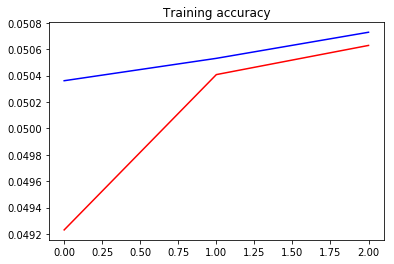

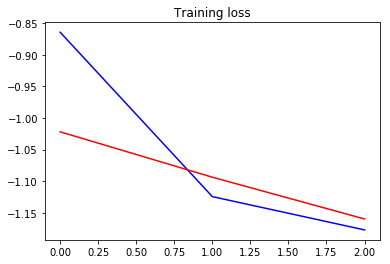

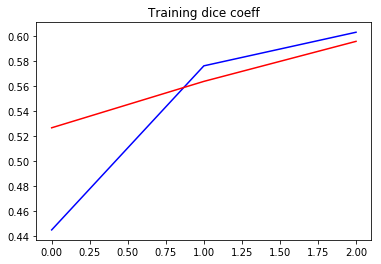

<Figure size 432x288 with 0 Axes>

In [36]:
plot_training(history)

#### Are the lower layers still not trainable?

In [37]:
layer = advanced_model.get_layer(index=11)
print(layer.get_config())

layer_256x1600_initially = layer.get_weights()[0][2][2][15]
print(layer_256x1600_initially)

{'name': 'conv2d_4', 'trainable': False, 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[ 0.19774145  0.0426113   0.00757337 -0.06391622  0.10728361  0.08970336
  0.09039313 -0.1798031   0.07129601  0.01274211 -0.15537432  0.01191017
 -0.18142171 -0.13882028  0.03663984 -0.03118151]


#### Lets make the layers trainable

In [38]:
# Takes roughly a minute
for idx in range(4, 96):
    layer_256x1600 = advanced_model.get_layer(index=(idx + 7))
    layer_256x1600.trainable=True


In [39]:
layer = advanced_model.get_layer(index=11)
print(layer.get_config())

{'name': 'conv2d_4', 'trainable': True, 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [40]:
advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [ ]:
PATIENCE = 2
EPOCHS = 3

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.98,1.02], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.01, height_shift_range=0.025,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

In [ ]:
plot_training(history)

In [ ]:
# this saves to unet_model_128x800_unsharp_4classes_v1

PATIENCE = 2
EPOCHS = 5

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    #shear_range=1, #OK
                                    #zoom_range=[0.98,1.02], # OK
                                    #rotation_range=1, #OK
                                    #width_shift_range=0.01, height_shift_range=0.025,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

In [ ]:
plot_training(history)